## **Data Analysis of the TumE superfamily of proteins**

- Author: Damien Legros
- Date: 26/05/2025

Using the sequence, taxonomic and functional perspectives I analysed the Tume superfamily of proteins and concluded on the questions using figures, plots, tables and calculations.

##### **Information on the data used in the analysis**

##### ```TumE.fasta```
- This file contains 860 protein sequences from the TumE superfamily, in FASTA format. 
- Each sequence’s header contains a UniProt Accession ID and a title, separated by a `|`.

##### ```TumE_annotations.fasta``` 
- This file  provides  annotations  for  each  of  the  860  proteins,  listed in the `uniprotAC` column. 
- The annotations include taxonomy (Superkingdom, Phylum, Taxa, Class, Family, Genus, Order and Species).
- Two gene ontology (GO) term predictions 1 and 2. The GO  terms  represent  function-related  predictions  generated  by  the  DeepFRI  tool.  
- For  most proteins, the two top scoring predicted terms are listed, however some may only have one, these cases will have an empty value in the `deepfri prediction 2` column. 

##### **Reference**
*Durairaj J, Waterhouse AM, Mets T, Brodiazhenko T, Abdullah M, Studer G, Tauriello G, Akdel M, Andreeva A, Bateman A, Tenson T, Hauryliuk V, Schwede T, Pereira J. Uncovering new families and folds in the natural protein universe. Nature. 2023 Oct;622(7983):646-653.*

##### **Libraries and setup**

In [1]:
## Libraries import
# Libraries used all over the notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# To open the fasta file
from Bio import SeqIO

import os

# Used for Q1:B) MEME motif discovery
from Bio.motifs import meme

# Used for Q1:C) AA Densities
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

# Used for Q1:D) Levenshstein Distance
from Levenshtein import ratio
from itertools import combinations 
import networkx as nx
from matplotlib.patches import Patch
import colorcet as cc

# Used for Q1:F) Rand Index and Mutual Information
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Used for Q2:B) Enrichement Analysis
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

# Remove Deprecation and Future Warnings
import warnings
from Bio import BiopythonDeprecationWarning
warnings.simplefilter('ignore', BiopythonDeprecationWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
## Load fasta and annotations and generate a Dataframe
# Load the fasta files and annotations
TumE_fastas = SeqIO.to_dict(SeqIO.parse('TumE.fasta', "fasta"))
TumE_annotations = pd.read_csv('TumE_annotations.csv')

# Function to retrieve the sequence from the fasta
def fasta_seq(fasta_id):
  return str(TumE_fastas.get(fasta_id).seq)

# Add the sequence to the dataframe according the uniprotAC
TumE_annotations['sequence'] = TumE_annotations['uniprotAC'].apply(fasta_seq)

#### **Question 1:** How many relevant sequence clusters, or protein families, are present within the TumE superfamily? Examine the similarities and differences among the provided sequences of the superfamily members to address this question.

##### A) Getting sequence clusters using MMseqs 

Add the cluster annotations inside the dataframe `TumE_annotations`

In [123]:
## Generate the sequence clusters using MMseqs at seq-id 0.9/0.7/0.5

# Check sequence cluster with 0.9 seq id
!mmseqs createdb TumE.fasta mmseqs_0.9/TumE_DB
!mmseqs cluster mmseqs_0.9/TumE_DB mmseqs_0.9/TumE_clu mmseqs_0.9/tmp --min-seq-id 0.9 -c 0.8
!mmseqs createseqfiledb mmseqs_0.9/TumE_DB mmseqs_0.9/TumE_clu mmseqs_0.9/TumE_clu_rep
!mmseqs result2flat mmseqs_0.9/TumE_DB TumE_DB mmseqs_0.9/TumE_clu_rep mmseqs_0.9/TumE_cluster_representatives.fasta
!mmseqs createtsv mmseqs_0.9/TumE_DB mmseqs_0.9/TumE_DB mmseqs_0.9/TumE_clu mmseqs_0.9/TumE_clusters.tsv
# Check sequence cluster with 0.7 seq id
!mmseqs createdb TumE.fasta mmseqs_0.7/TumE_DB
!mmseqs cluster mmseqs_0.7/TumE_DB mmseqs_0.7/TumE_clu mmseqs_0.7/tmp --min-seq-id 0.7 -c 0.8
!mmseqs createseqfiledb mmseqs_0.7/TumE_DB mmseqs_0.7/TumE_clu mmseqs_0.7/TumE_clu_rep
!mmseqs result2flat mmseqs_0.7/TumE_DB TumE_DB mmseqs_0.7/TumE_clu_rep mmseqs_0.7/TumE_cluster_representatives.fasta
!mmseqs createtsv mmseqs_0.7/TumE_DB mmseqs_0.7/TumE_DB mmseqs_0.7/TumE_clu mmseqs_0.7/TumE_clusters.tsv
# Check sequence cluster with 0.5 seq id
!mmseqs createdb TumE.fasta mmseqs_0.5/TumE_DB
!mmseqs cluster mmseqs_0.5/TumE_DB mmseqs_0.5/TumE_clu mmseqs_0.5/tmp --min-seq-id 0.5 -c 0.8
!mmseqs createseqfiledb mmseqs_0.5/TumE_DB mmseqs_0.5/TumE_clu mmseqs_0.5/TumE_clu_rep
!mmseqs result2flat mmseqs_0.5/TumE_DB TumE_DB mmseqs_0.5/TumE_clu_rep mmseqs_0.5/TumE_cluster_representatives.fasta
!mmseqs createtsv mmseqs_0.5/TumE_DB mmseqs_0.5/TumE_DB mmseqs_0.5/TumE_clu mmseqs_0.5/TumE_clusters.tsv


mmseqs_0.9/TumE_DB exists and will be overwritten
createdb TumE.fasta mmseqs_0.9/TumE_DB 

MMseqs Version:       	16.747c6
Database type         	0
Shuffle input database	true
Createdb mode         	0
Write lookup file     	1
Offset of numeric ids 	0
Compressed            	0
Verbosity             	3

Converting sequences
[809] 0s 6ms
Time for merging to TumE_DB_h: 0h 0m 0s 1ms
Time for merging to TumE_DB: 0h 0m 0s 1ms
Database type: Aminoacid
Time for processing: 0h 0m 0s 12ms
cluster mmseqs_0.9/TumE_DB mmseqs_0.9/TumE_clu mmseqs_0.9/tmp --min-seq-id 0.9 -c 0.8 

MMseqs Version:                     	16.747c6
Substitution matrix                 	aa:blosum62.out,nucl:nucleotide.out
Seed substitution matrix            	aa:VTML80.out,nucl:nucleotide.out
Sensitivity                         	4
k-mer length                        	0
Target search mode                  	0
k-score                             	seq:2147483647,prof:2147483647
Alphabet size                       	aa:21,nucl:5
Max s

In [3]:
## Use the representative sequence as label for the cluster for each seq-id level
# Add the mmseqs 0.9 seq-id annotation dataframe
data = pd.read_csv("mmseqs_0.9/TumE_clusters.tsv", sep="\t", header=None, names=["mmseqs_0.9", "member"])
TumE_annotations = TumE_annotations.merge(data, left_on="uniprotAC", right_on="member", how="left")
TumE_annotations = TumE_annotations.drop(columns=["member"])
# Add the mmseqs 0.7 seq-id annotation dataframe
data = pd.read_csv("mmseqs_0.7/TumE_clusters.tsv", sep="\t", header=None, names=["mmseqs_0.7", "member"])
TumE_annotations = TumE_annotations.merge(data, left_on="uniprotAC", right_on="member", how="left")
TumE_annotations = TumE_annotations.drop(columns=["member"])
# Add the mmseqs 0.5 seq-id annotation dataframe
data = pd.read_csv("mmseqs_0.5/TumE_clusters.tsv", sep="\t", header=None, names=["mmseqs_0.5", "member"])
TumE_annotations = TumE_annotations.merge(data, left_on="uniprotAC", right_on="member", how="left")
TumE_annotations = TumE_annotations.drop(columns=["member"])

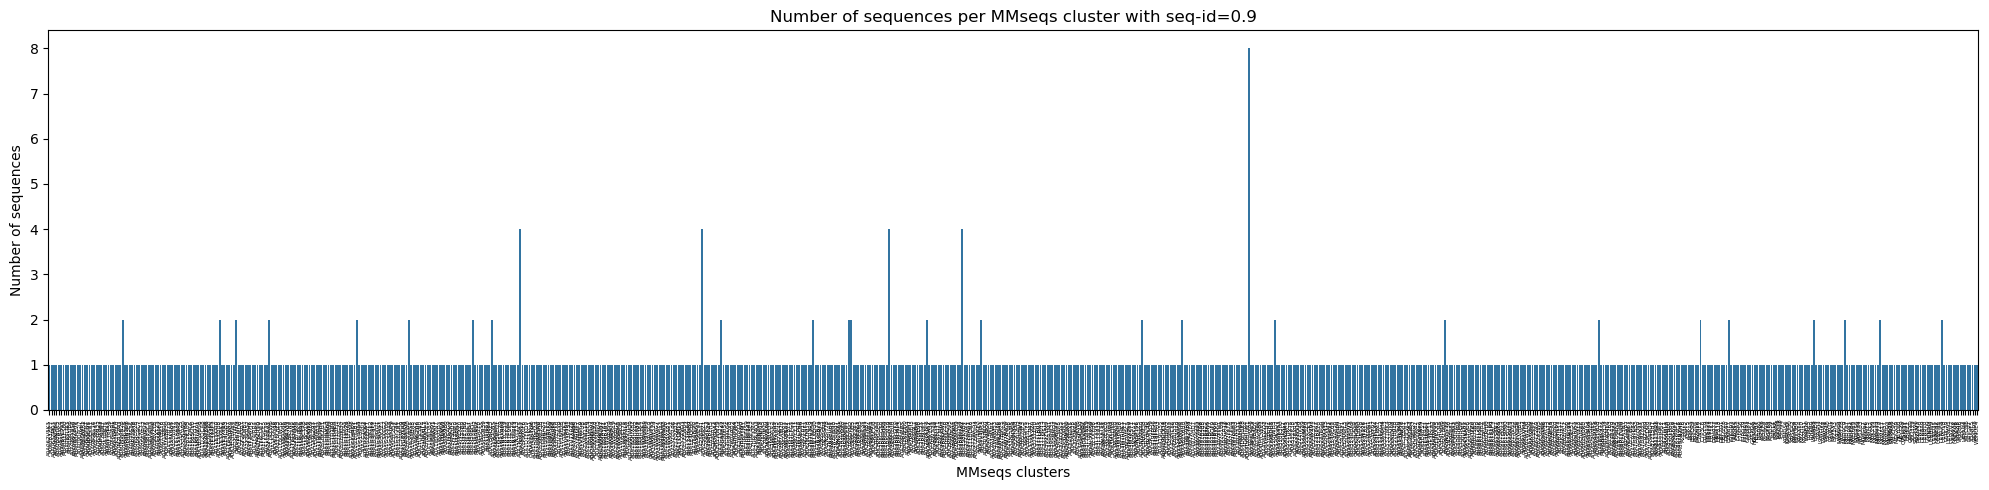

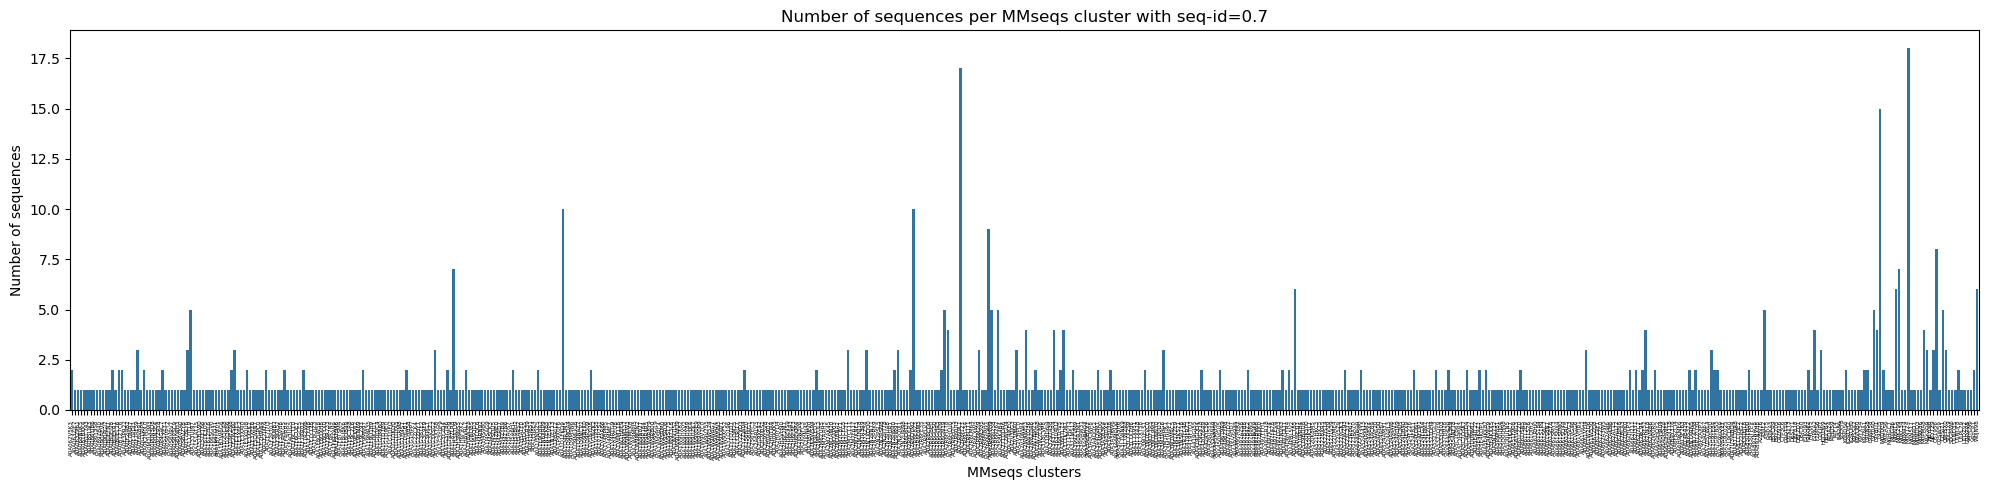

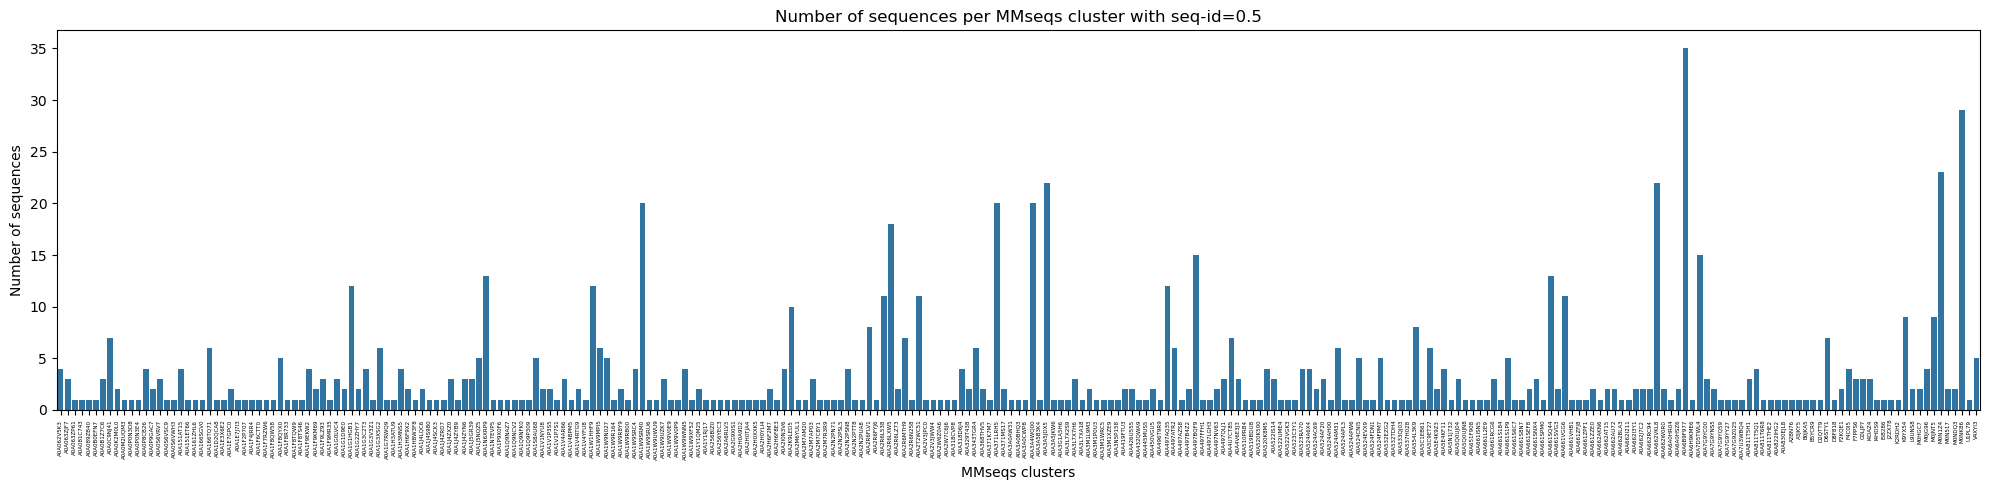

In [4]:
## Generate a barplot of the number of sequence per cluster
for clusters in ['mmseqs_0.9', 'mmseqs_0.7', 'mmseqs_0.5']:
    tmp = TumE_annotations.groupby([clusters]).size().reset_index()
    tmp.rename(columns={tmp.columns[1]: 'Number of sequences', tmp.columns[0]: 'MMseqs clusters'}, inplace=True)
    plt.figure(figsize=(20, 5))
    plt.title('Number of sequences per MMseqs cluster with seq-id=' + clusters.split('_')[1])
    sns.barplot(data=tmp, x='MMseqs clusters', y='Number of sequences')
    plt.xticks(rotation=90, fontsize=4)
    plt.tight_layout() 
    plt.show()

##### B) Getting sequence clusters using MEME

Add the cluster annotations inside the dataframe `TumE_annotations`

In [ ]:
## Run the MEME software to find motif in the TumE Superfamily
# To access MEME in the notebook and use it
os.environ['PATH'] = "/usr/local/meme/bin:" + os.environ['PATH']
!meme TumE.fasta -oc meme -protein -mod zoops -nmotifs 5 -minw 6 -maxw 20

The output directory 'meme' already exists.
Its contents will be overwritten.
BACKGROUND: using background model of order 0
PRIMARY (classic): n 860 p0 787 p1 73 p2 0
SEQUENCE GROUP USAGE-- Starts/EM: p0; Trim: p0; pvalue: p0; nsites: p0,p1,p2
SEEDS: maxwords 60316 highwater mark: seq 497 pos 7
Initializing the motif probability tables for 2 to 787 sites...
nsites = 787
Done initializing.

seqs=   860, min_w=  57, max_w=  425, total_size=   109459

motif=1
SEED DEPTHS: 2 4 8 16 32 64 128 256 512 787
SEED WIDTHS: 6 8 11 15 20
em: w=  20, psites= 787, iter=  20 Warning: Cannot convert EPS file to PNG as no install of Image Magick or Ghostscript is usable.

motif=2
SEED DEPTHS: 2 4 8 16 32 64 128 256 512 787
SEED WIDTHS: 6 8 11 15 20
em: w=  20, psites= 787, iter=   0 Warning: Cannot convert EPS file to PNG as no install of Image Magick or Ghostscript is usable.

motif=3
SEED DEPTHS: 2 4 8 16 32 64 128 256 512 787
SEED WIDTHS: 6 8 11 15 20
em: w=  20, psites= 787, iter=  10 Warning: Canno

In [5]:
## Extract the motifs from the MEME output
# Open the MEME xml file
with open("meme/meme.xml") as meme_xml:
    meme_output = meme.read(meme_xml)

# Set up two default dict to add the motif (start, pval, site) inside
# Corresponding to 3 columns * 5 motifs (start, pval, site)
seq_data = defaultdict(lambda: [None]*15)
# For each sequence add the motifs (start, index) 
motif_order = defaultdict(list) 
# For each motif in the meme_output
for motif_index, motif in enumerate(meme_output, start=1):
    # For each instance seen of that motif
    for instance in motif.instances:
        # Get instance sequence_id with the motif
        seq_id = instance.sequence_name
        # Add (start, pval, site) of the instance to the sequence_id in the dict
        base = (motif_index - 1) * 3
        seq_data[seq_id][base] = instance.start
        seq_data[seq_id][base + 1] = instance.pvalue
        seq_data[seq_id][base + 2] = str(instance)
        # Add (start, index) of the instance to the sequence_id in the dict
        motif_order[seq_id].append((instance.start, motif_index))

# Create the rows of the output dataframe
rows = []
for seq_id, values in seq_data.items():
    # Join the motif indexes as a motif cluster
    motif_cluster = ''.join(str(m) for _, m in sorted(motif_order[seq_id]))
    rows.append([seq_id] + values + [motif_cluster])

# Create the column names
columns = ["Sequence_ID"]
for i in range(1, 6):
    columns += [f"Start_M{i}", f"Pval_M{i}", f"Site_M{i}"]
columns.append("Motif_Cluster")
# Generate the DataFrame
data = pd.DataFrame(rows, columns=columns)

# Function to get the Motif Cluster from the Sequence ID
def meme_cluster(fasta_id):
    row = data[data['Sequence_ID'] == fasta_id]
    if not row.empty:
        return row['Motif_Cluster'].values[0]
    else:
        return None

TumE_annotations['meme'] = TumE_annotations['uniprotAC'].apply(meme_cluster)
TumE_annotations['meme'] = TumE_annotations['meme'].fillna('Empty')

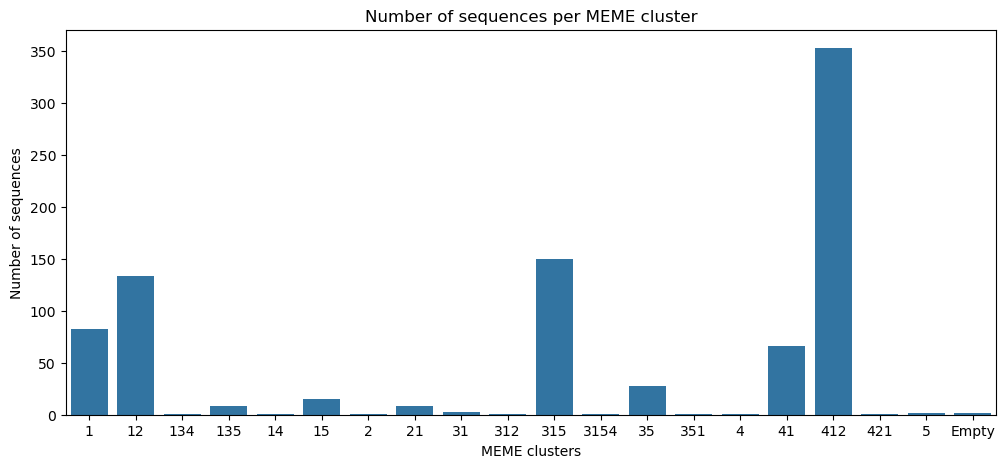

In [6]:
## Generate a barplot of the number of sequence per cluster
tmp = TumE_annotations.groupby(['meme']).size().reset_index()
tmp.rename(columns={tmp.columns[1]: 'Number of sequences', tmp.columns[0]: 'MEME clusters'}, inplace=True)
plt.figure(figsize=(12, 5))
plt.title('Number of sequences per MEME cluster')
sns.barplot(data=tmp, x='MEME clusters', y='Number of sequences')
plt.show()

##### C) Getting sequence clusters using the relative density of amino acids

Add annotations to the density dataframe named data_aa

In [7]:
## Define the relative aminoacid density for each sequence
def make_aa_density(seq, n=16):
    data = pd.DataFrame()
    # Cut the sequence in n subsequences and add them to data
    for i in range(n):
        subseq = seq[int((i/n)*len(seq)):int(((i+1)/n)*len(seq))]
        # Get th aa counts of the subsequence
        tmp = pd.Series(list(subseq)).value_counts().reset_index().T
        # Use the index (aminoacids) as columns
        tmp.columns = tmp.loc['index']
        # Keep only the aa counts and fill NaN with 0
        tmp = tmp.loc[['count']]
        # Add the subsequence to 
        data = pd.concat([data, tmp]).fillna(0)
    # Get the percentage of each aminoacid per subsequence
    data = data.divide(data.sum(axis=0))
    data['subsequence'] = ['sseq' + str(i+1) for i in range(n)]
    data = pd.melt(data, id_vars = ['subsequence'])
    # Merge the subsequence and amino acids column names
    data['id'] = data['subsequence'] + '_' + data['index']
    # Keep for each AA count per subsequence the percentage per sequence
    data = data[['id', 'value']].T
    # Add the AA count per subsequence names as columns
    data.columns = data.loc['id']
    data = data.loc[['value']]
    data['seq'] = seq
    return [data]

aa_densities = TumE_annotations.groupby('sequence').apply(lambda x: make_aa_density(list(x['sequence'])[0]))
# Retrieve only the aa_densities as a single DataFrame
aa_densities = pd.concat(sum(aa_densities, [])).fillna(0)

In [8]:
## Calculate the PC1 and PC2
# Apply -log2 on the densities
aa_densities_log = -np.log2(aa_densities.drop('seq', axis=1).replace(0, 1e-5))
# Calculate the PC 1 and 2 of the aa densities 
pca_function = PCA(n_components=2, random_state=42)
aa_pc = pca_function.fit_transform(aa_densities_log)
pca_densities = pd.DataFrame(aa_pc)
pca_densities['sequence'] = list(aa_densities['seq'])

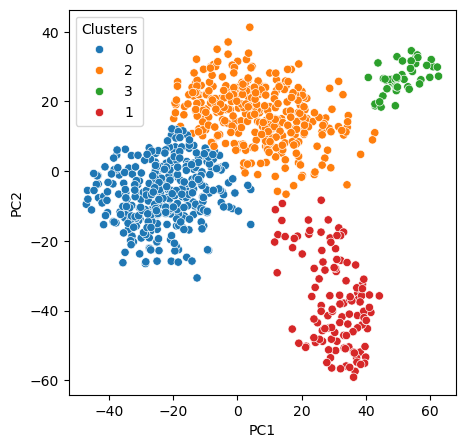

In [9]:
## Use Gaussian Mixture to divide clusters in the PCA
# Compute the Gaussian Mixture on the AA PC
gm = GaussianMixture(n_components=4, random_state=42).fit(aa_pc)
# Add the clusters to the dataframe
pca_densities['Clusters'] = [str(i) for i in gm.predict(aa_pc)]
pca_densities.rename(columns={pca_densities.columns[0]: 'PC1', pca_densities.columns[1]: 'PC2'}, inplace=True)
plt.figure(figsize=(5, 5))
sns.scatterplot(data=pca_densities, x='PC1', y='PC2', hue='Clusters')
pca_densities.rename(columns={pca_densities.columns[3]: 'AA_density'}, inplace=True)
TumE_annotations = TumE_annotations.merge(pca_densities[['sequence', 'PC1', 'PC2', 'AA_density']], left_on='sequence', right_on='sequence')

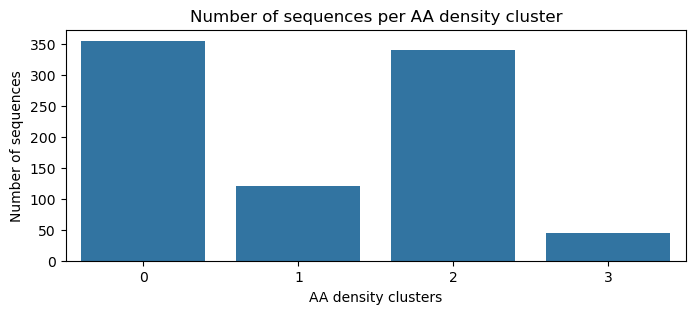

In [10]:
## Generate a barplot of the number of sequence per cluster
tmp = TumE_annotations.groupby(['AA_density']).size().reset_index()
tmp.rename(columns={tmp.columns[1]: 'Number of sequences', tmp.columns[0]: 'AA density clusters'}, inplace=True)
plt.figure(figsize=(8, 3))
plt.title('Number of sequences per AA density cluster')
sns.barplot(data=tmp, x='AA density clusters', y='Number of sequences')
plt.show()

##### D) Getting sequence clusters using the Levenhstein distance between sequences

Explain Levenshstein distance and what was done

In [11]:
## Get the sequence combinations and compute the levenshtein ratio
# Get all the combinations of 2 sequences from the TumE Superfamily
comb_seq = list(combinations(list(TumE_annotations['sequence']), 2))

# Compute the Levenshstein ratio for every combination of 2 sequences in the TumE Superfamily
leven_df = pd.DataFrame()
for i in tqdm(range(len(comb_seq)), desc='Compute the Levenshstein ratio for every combination'):
    value = ratio(comb_seq[i][0], comb_seq[i][1])
    leven_df = pd.concat([leven_df, pd.DataFrame({'seq1': [comb_seq[i][0]], 'seq2': [comb_seq[i][1]], 'ratio': [value]})])

Compute the Levenshstein ratio for every combination: 100%|██████████| 369370/369370 [08:42<00:00, 707.19it/s] 


Text(0, 0.5, 'Number of clusters')

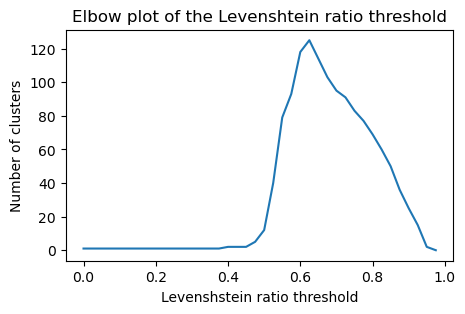

In [12]:
## Generate an elbow plot of the number of clusters and select the ratio
ratios = []
nb_clusters = []
for i in np.arange(0, 1, 0.025):
    ratios.append(i)
    # Keep only the sequence combinations with levenshstein ration > i
    filtered_leven = leven_df[leven_df['ratio'] >= i].drop('ratio', axis=1)
    G = nx.Graph()
    # Add edges for those combinations
    G.add_edges_from(filtered_leven.values)
    # Get the connected sequences as clusters
    connected_seqs = list(nx.connected_components(G))
    nb_clusters.append(len(connected_seqs))

plt.figure(figsize=(5, 3))
plt.title("Elbow plot of the Levenshtein ratio threshold")
plt.plot(ratios, nb_clusters)
plt.xlabel("Levenshstein ratio threshold")
plt.ylabel("Number of clusters")

In [13]:
## Find Levenshtein clusters with ratio threshold 0.5
# Keep only the sequence combinations with levenshstein ratio > 0.5
filtered_leven = leven_df[leven_df['ratio'] >= 0.5].drop('ratio', axis=1)
G = nx.Graph()
# Add edges for those combinations
G.add_edges_from(filtered_leven.values)
# Get the connected sequences as clusters
connected_seqs = list(nx.connected_components(G))
seq_cluster = [(seq, f"cluster_{i}") for i, cluster in enumerate(connected_seqs) for seq in cluster]
data = pd.DataFrame(seq_cluster, columns=['sequence', 'levenshtein'])
TumE_annotations = TumE_annotations.merge(data, left_on='sequence', right_on='sequence')

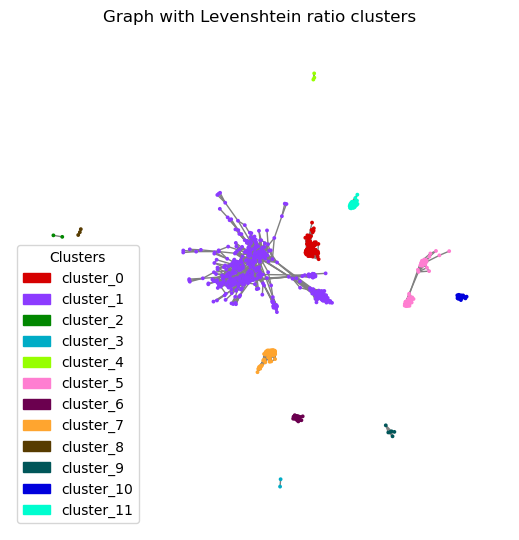

In [14]:
## Generate a graph plot of the Levenshtein clusters
# Convert cluster names to int to give them a unique color
unique_labels = data['levenshtein'].unique()
label_to_int = {label: i for i, label in enumerate(unique_labels)}
cluster_dict = data.set_index('sequence')['levenshtein'].to_dict()
colors = cc.glasbey[:len(unique_labels)]
# List of color to give each node a color corresponding to the cluster
node_color_values = [colors[label_to_int[cluster_dict[node]]] for node in G.nodes()]

plt.figure(figsize=(5, 5))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos,
        node_color=node_color_values,
        edge_color='gray',
        node_size=3)

# Add the legend to the graph plot
legend_handles = [Patch(color=colors[i], label=label) for label, i in label_to_int.items()]
plt.legend(handles=legend_handles, title="Clusters", loc='best')
plt.title("Graph with Levenshtein ratio clusters")
plt.show()

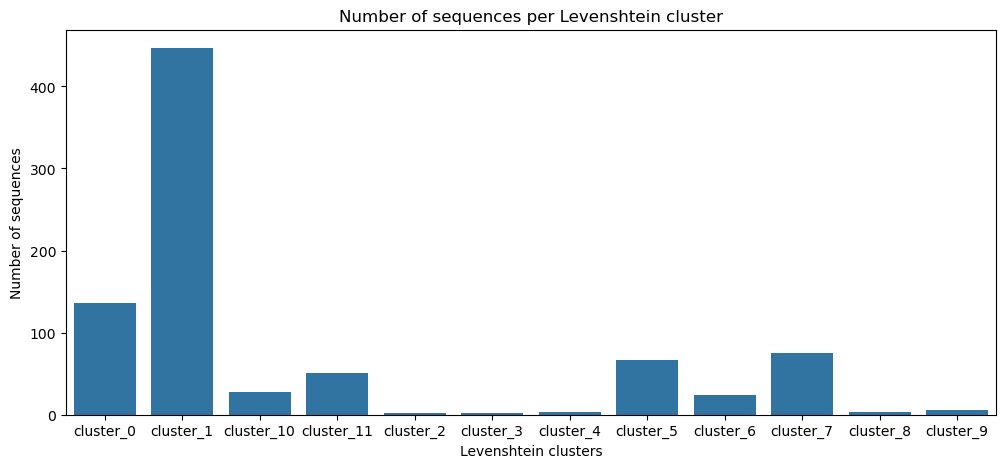

In [15]:
## Generate a barplot of the number of sequence per cluster
tmp = TumE_annotations.groupby(['levenshtein']).size().reset_index()
tmp.rename(columns={tmp.columns[1]: 'Number of sequences', tmp.columns[0]: 'Levenshtein clusters'}, inplace=True)
plt.figure(figsize=(12, 5))
plt.title('Number of sequences per Levenshtein cluster')
sns.barplot(data=tmp, x='Levenshtein clusters', y='Number of sequences')
plt.show()

##### E) Investigation over the sequence clusters

In [16]:
## Show the column names for the sequence clusters
pd.DataFrame(list(TumE_annotations.columns), columns=['columns'])

,columns
0,uniprotAC
1,superkingdom
2,phylum
3,class
4,order
5,family
6,genus
7,species
8,deepfri prediction1
9,deepfri prediction2


In [17]:
## Values to change for investigation between sequence clusters
cluster_type1 = 'meme'
cluster_type2 = 'mmseqs_0.5'
threshold_size = 5

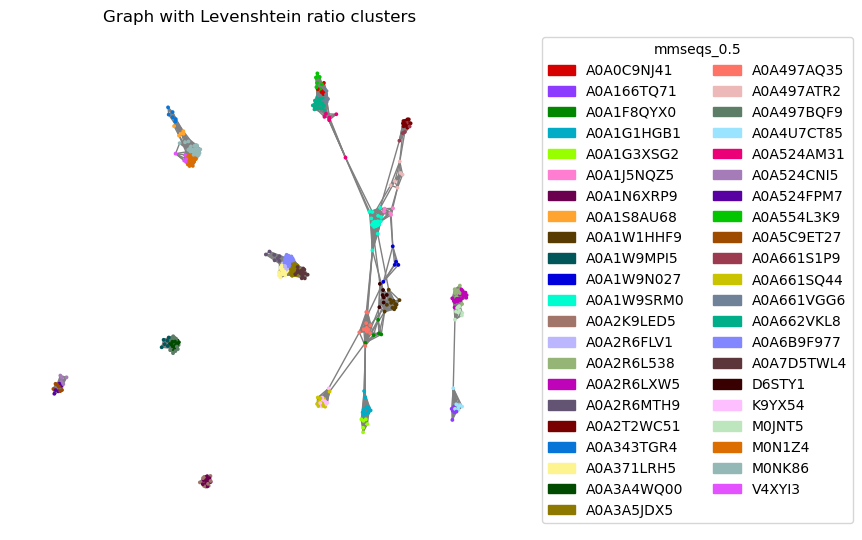

In [18]:
## Generate a graph plot of the Levenshtein clusters with annotations corresponding to cluster_type2
# Take away cluster_type2 annotations with less than the threshold_size
valid_clusters = TumE_annotations[cluster_type2].value_counts()
valid_clusters = valid_clusters[valid_clusters >= threshold_size].index
df_clusters_filtered = TumE_annotations[TumE_annotations[cluster_type2].isin(valid_clusters)]

# Filter edges to keep only the ones with cluster_type2 annotations higher than the threshold size
valid_nodes = set(df_clusters_filtered['sequence'])
filtered_edges = filtered_leven[filtered_leven['seq1'].isin(valid_nodes) & filtered_leven['seq2'].isin(valid_nodes)]

filtered_G = nx.Graph()
filtered_G.add_edges_from(filtered_edges.values)

# Give to each cluster_type2 annotation a int to give it a color
unique_annotations = np.sort(df_clusters_filtered[cluster_type2].unique())
annot_to_int = {annot: i for i, annot in enumerate(unique_annotations)}
cluster_dict = df_clusters_filtered.set_index('sequence')[cluster_type2].to_dict()
colors = cc.glasbey[:len(unique_annotations)]

# List of color corresponding to each cluster_type2 annotation per node
node_color_values = [colors[annot_to_int[cluster_dict[node]]] for node in filtered_G.nodes()]

plt.figure(figsize=(5, 5))
pos = nx.spring_layout(filtered_G, seed=42)
nx.draw(filtered_G, pos,
        node_color=node_color_values,
        edge_color='gray',
        node_size=3)

legend_handles = [Patch(color=colors[i], label=annot) for annot, i in annot_to_int.items()]
plt.legend(ncol=2, handles=legend_handles, title=cluster_type2, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title("Graph with Levenshtein ratio clusters")
plt.show()

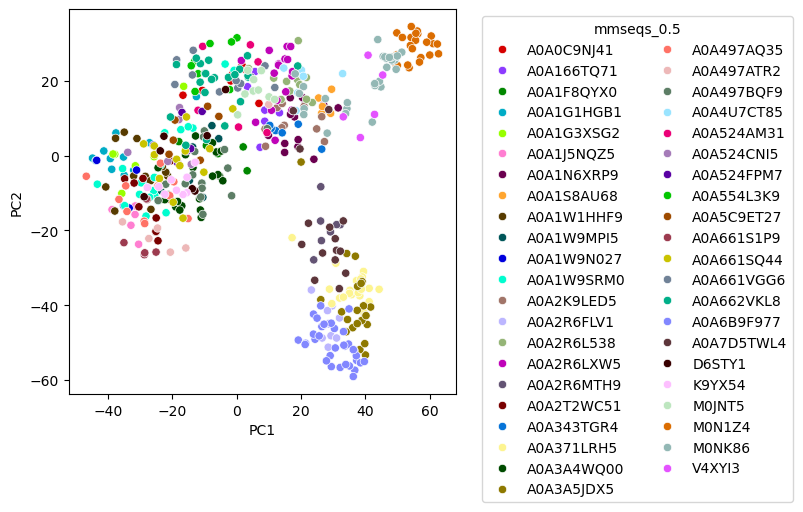

In [19]:
## Generate the PCA plot of the AA densities with annotations corresponding to cluster_type2
# Take away cluster_type2 annotations with less than the threshold_size
tmp = TumE_annotations.groupby(cluster_type2).size().reset_index(name='Number of sequences')
cluster_counts = tmp.groupby(cluster_type2)['Number of sequences'].sum()
valid_clusters = cluster_counts[cluster_counts >= threshold_size].index
tmp = TumE_annotations[TumE_annotations[cluster_type2].isin(valid_clusters)].sort_values(by=[cluster_type2])

plt.figure(figsize=(5, 5))
sns.scatterplot(data=tmp, x='PC1', y='PC2', hue=cluster_type2, palette=colors)
plt.legend(ncol=2, title=cluster_type2, bbox_to_anchor=(1.05, 1.0), loc='upper left')

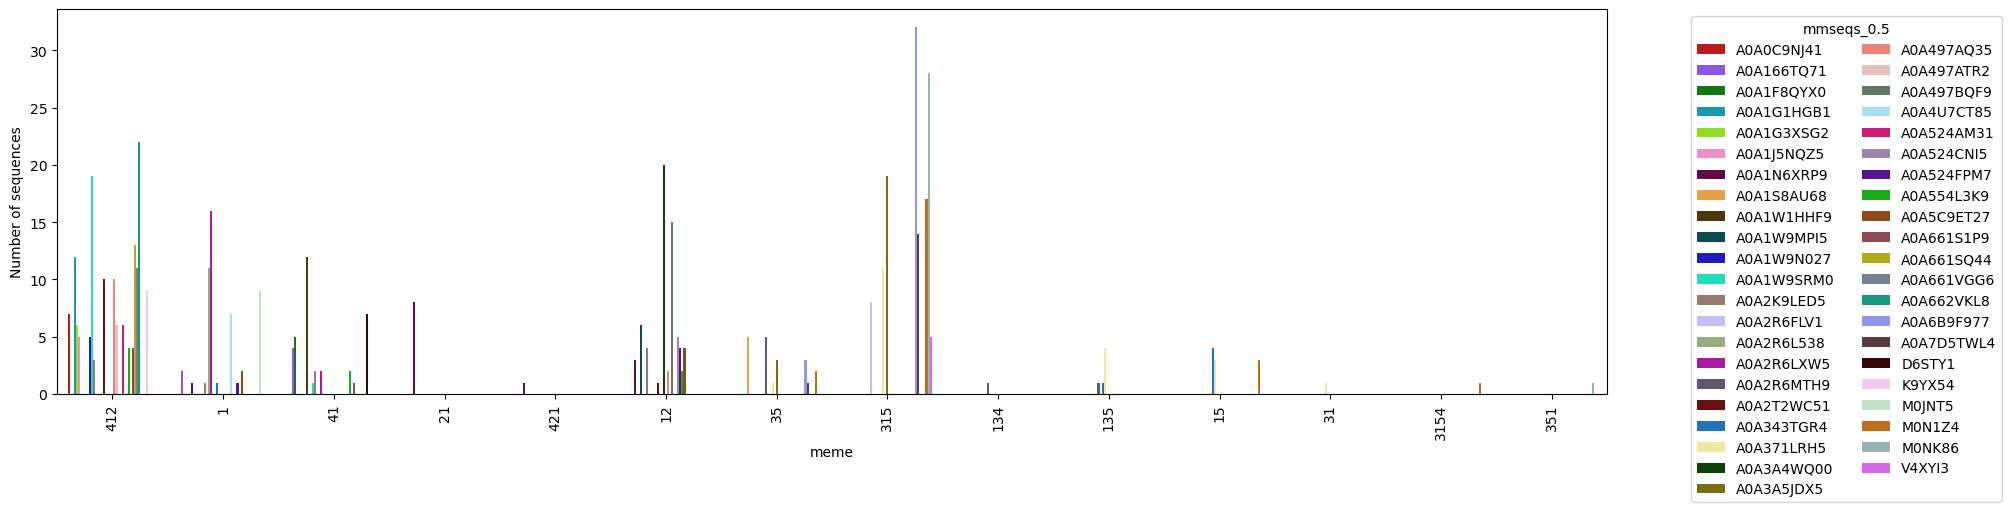

In [20]:
## Generate a barplot of cluster_type1 with annotations corresponding to cluster_type2
# Group and count sequences per combination of cluster_type1 and cluster_type2
tmp = TumE_annotations.groupby([cluster_type1, cluster_type2]).size().reset_index(name='Number of sequences')

# Take away cluster_type1 annotations with less than the n
n = 0
cluster_counts = tmp.groupby(cluster_type1)['Number of sequences'].sum()
valid_clusters = cluster_counts[cluster_counts >= n].index
tmp = tmp[tmp[cluster_type1].isin(valid_clusters)].sort_values(by=[cluster_type2])

# Take away cluster_type2 annotations with less than the threshold_size
cluster_counts = tmp.groupby(cluster_type2)['Number of sequences'].sum()
valid_clusters = cluster_counts[cluster_counts >= threshold_size].index
tmp = tmp[tmp[cluster_type2].isin(valid_clusters)].sort_values(by=[cluster_type2])

plt.figure(figsize=(20, 5))
sns.barplot(data=tmp, x=cluster_type1, y='Number of sequences', hue=cluster_type2, palette=colors)
plt.xlabel(cluster_type1)
plt.ylabel('Number of sequences')
plt.legend(ncol=2, title=cluster_type2, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xticks(rotation=90)
plt.show()

##### F) Size of clusters, Rand Index and Mutual Information

In [21]:
## Cluster size, counts, max, min
cluster_methods = ['mmseqs_0.5', 'meme', 'AA_density', 'levenshtein']

summary = []
for method in cluster_methods:
    counts = TumE_annotations[method].value_counts()
    cluster_sizes_ge2 = counts[counts > 2]
    cluster_sizes_le2 = counts[counts <= 2]
    summary.append({
        'method': method,
        'nb_clusters >2': len(cluster_sizes_ge2),
        'nb_clusters ≤2': len(cluster_sizes_le2),
        'max_cluster_size': counts.max(),
        'min_cluster_size ≥2': cluster_sizes_ge2.min()
    })

summary_TumE_annotations = pd.DataFrame(summary)
summary_TumE_annotations

,method,nb_clusters >2,nb_clusters ≤2,max_cluster_size,min_cluster_size ≥2
0,mmseqs_0.5,85,168,35,3
1,meme,9,11,348,8
2,AA_density,4,0,349,45
3,levenshtein,10,2,447,3


In [22]:
## Compute the pairwise Adjusted Rand Score (ARI) and Normalized Mutual Information (NMI)
pairwise_metrics = []

for i in range(len(cluster_methods)):
    for j in range(i + 1, len(cluster_methods)):
        m1 = cluster_methods[i]
        m2 = cluster_methods[j]
        ari = adjusted_rand_score(TumE_annotations[m1], TumE_annotations[m2])
        nmi = normalized_mutual_info_score(TumE_annotations[m1], TumE_annotations[m2])
        pairwise_metrics.append({
            'method_1': m1,
            'method_2': m2,
            'ARI': round(ari, 3),
            'NMI': round(nmi, 3)
        })

pairwise_df = pd.DataFrame(pairwise_metrics)
pairwise_df

,method_1,method_2,ARI,NMI
0,mmseqs_0.5,meme,0.051,0.460
1,mmseqs_0.5,AA_density,0.033,0.332
2,mmseqs_0.5,levenshtein,0.044,0.473
3,meme,AA_density,0.214,0.334
4,meme,levenshtein,0.577,0.602
5,AA_density,levenshtein,0.310,0.469


##### G) Conclusion

- **MMseqs with a sequence identity of 0.5**, produce the highest number of small clusters (168), which can not be seen are relevant clusters, the Adjusted Rand Score is always lower than 0.05 with all the other methods indicating that the others methods do not use the same cluster strategies. This show us than using kmers analysis might not be the best to obtain relevant sequence clusters to identify protein families in the TumE Superfamily.
- **The aminoacid densities clustering with a PCA**, produce the lowest number of cluster (4) and has low similarity with the MEME and Levenshtein ratio, because of only 3-4 components showing in the PCA, this method might over-aggregates protein families and is probably missing some finer distinctions.
- **MEME and Levenshtein ratio** offers a medium number of clusters (9 clusters of size>2). It shows a moderate similarity with the Levenshtein ratio method. MEME Motif discovery method uses Position Weight Matrices with Expectation-Maximization (EM) and this might bring similar information than using the levenshtein ratio between sequences. This make sense as the Levenshtein distance tells us about the number of insertion, deletion, etc needed between two sequences. The probability of having an aminoacid at a specific position bring also the info on insertion, deletion that happens at this position.

In the end we have **9 clusters from MEME** and **10 clusters from Levenshtein** that might be relevant to identify protein families inside the TumE Superfamily. The two other methods will also be investigated to see what information can be picked up from them.

#### **Question 2:** Integrate your sequence cluster analysis with the taxonomy and predicted functions data. Do the taxonomy and function distributions within sequence clusters match what you would expect?

##### A) Investigation over the sequence clusters, taxonomy and deepfri functions

In [23]:
## Make a consensus of deepfri predictions
# Count the number of sequences for each function type
deepfri_preds = pd.concat([TumE_annotations['deepfri prediction1'], TumE_annotations['deepfri prediction2']])
deepfri_counts = deepfri_preds.value_counts()

# Assign the function with the highest count
def consensus_function(row):
    function1, function2 = row['deepfri prediction1'], row['deepfri prediction2']
    if pd.isna(function1) and pd.isna(function2):
        return np.nan
    if pd.isna(function2):
        return function1
    return function1 if deepfri_counts.get(function1, 0) >= deepfri_counts.get(function2, 0) else function2


TumE_annotations['deepfri consensus'] = TumE_annotations.apply(consensus_function, axis=1)

In [24]:
## Show the column names for the sequence clusters, taxonomy and deepfri functions
pd.DataFrame(list(TumE_annotations.columns), columns=['columns'])

,columns
0,uniprotAC
1,superkingdom
2,phylum
3,class
4,order
5,family
6,genus
7,species
8,deepfri prediction1
9,deepfri prediction2


In [43]:
## Values to change for investigation between sequence clusters, taxonomy and deepfri functions
cluster_type1 = 'meme'
cluster_type2 = 'class'
threshold_size = 2

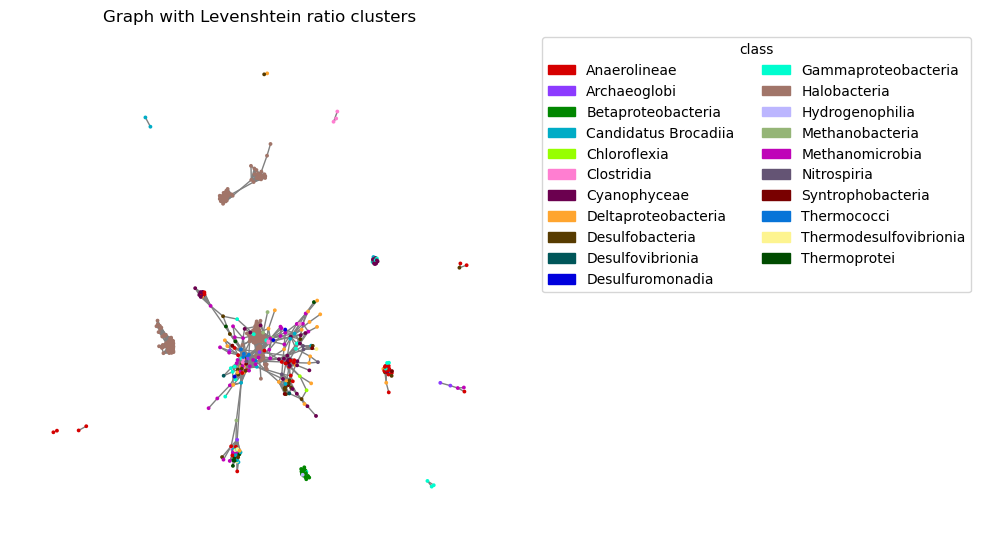

In [45]:
## Generate a graph plot of the Levenshtein clusters with annotations corresponding to cluster_type2
# Take away cluster_type2 annotations with less than the threshold_size
valid_clusters = TumE_annotations[cluster_type2].value_counts()
valid_clusters = valid_clusters[valid_clusters >= threshold_size].index
df_clusters_filtered = TumE_annotations[TumE_annotations[cluster_type2].isin(valid_clusters)]

# Filter edges to keep only the ones with cluster_type2 annotations higher than the threshold size
valid_nodes = set(df_clusters_filtered['sequence'])
filtered_edges = filtered_leven[filtered_leven['seq1'].isin(valid_nodes) & filtered_leven['seq2'].isin(valid_nodes)]

filtered_G = nx.Graph()
filtered_G.add_edges_from(filtered_edges.values)

# Give to each cluster_type2 annotation a int to give it a color
unique_annotations = np.sort(df_clusters_filtered[cluster_type2].unique())
annot_to_int = {annot: i for i, annot in enumerate(unique_annotations)}
cluster_dict = df_clusters_filtered.set_index('sequence')[cluster_type2].to_dict()
colors = cc.glasbey[:len(unique_annotations)]

# List of color corresponding to each cluster_type2 annotation per node
node_color_values = [colors[annot_to_int[cluster_dict[node]]] for node in filtered_G.nodes()]

plt.figure(figsize=(5, 5))
pos = nx.spring_layout(filtered_G, seed=42)
nx.draw(filtered_G, pos,
        node_color=node_color_values,
        edge_color='gray',
        node_size=3)

legend_handles = [Patch(color=colors[i], label=annot) for annot, i in annot_to_int.items()]
plt.legend(ncol=2, handles=legend_handles, title=cluster_type2, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title("Graph with Levenshtein ratio clusters")
plt.show()

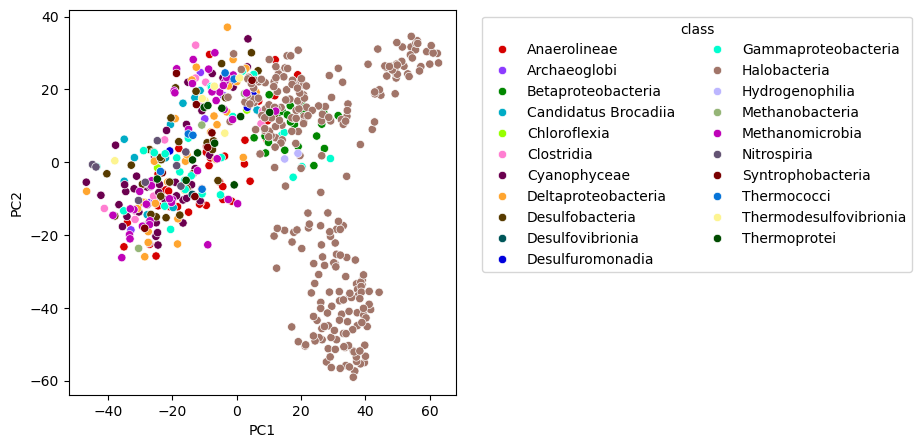

In [46]:
## Generate the PCA plot of the AA densities with annotations corresponding to cluster_type2
# Take away cluster_type2 annotations with less than the threshold_size
tmp = TumE_annotations.groupby(cluster_type2).size().reset_index(name='Number of sequences')
cluster_counts = tmp.groupby(cluster_type2)['Number of sequences'].sum()
valid_clusters = cluster_counts[cluster_counts >= threshold_size].index
tmp = TumE_annotations[TumE_annotations[cluster_type2].isin(valid_clusters)].sort_values(by=[cluster_type2])

plt.figure(figsize=(5, 5))
sns.scatterplot(data=tmp, x='PC1', y='PC2', hue=cluster_type2, palette=colors)
plt.legend(ncol=2, title=cluster_type2, bbox_to_anchor=(1.05, 1.0), loc='upper left')

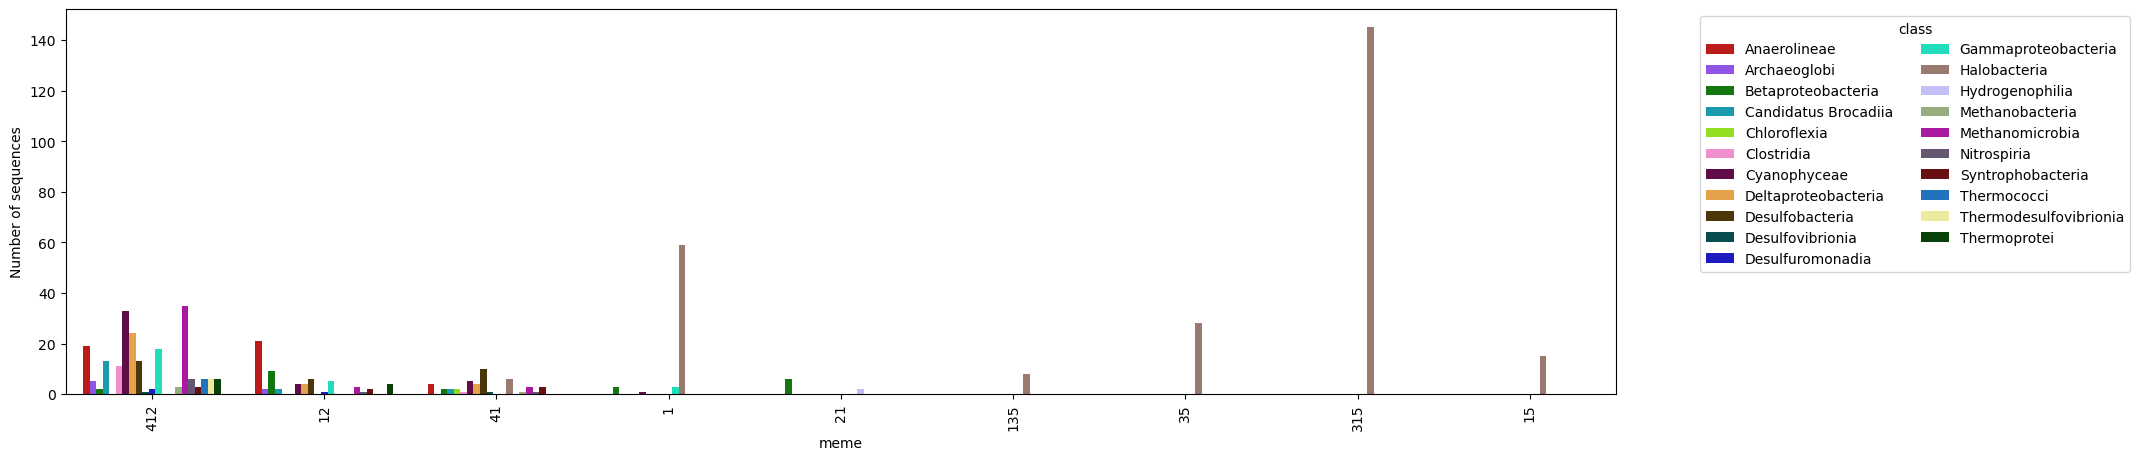

In [47]:
## Generate a barplot of cluster_type1 with annotations corresponding to cluster_type2
# Group and count sequences per combination of cluster_type1 and cluster_type2
tmp = TumE_annotations.groupby([cluster_type1, cluster_type2]).size().reset_index(name='Number of sequences')

# Take away cluster_type1 annotations with less than the n
n = 3
cluster_counts = tmp.groupby(cluster_type1)['Number of sequences'].sum()
valid_clusters = cluster_counts[cluster_counts >= n].index
tmp = tmp[tmp[cluster_type1].isin(valid_clusters)].sort_values(by=[cluster_type2])

# Take away cluster_type2 annotations with less than the threshold_size
cluster_counts = tmp.groupby(cluster_type2)['Number of sequences'].sum()
valid_clusters = cluster_counts[cluster_counts >= threshold_size].index
tmp = tmp[tmp[cluster_type2].isin(valid_clusters)].sort_values(by=[cluster_type2])

plt.figure(figsize=(20, 5))
sns.barplot(data=tmp, x=cluster_type1, y='Number of sequences', hue=cluster_type2, palette=colors)
plt.xlabel(cluster_type1)
plt.ylabel('Number of sequences')
plt.legend(ncol=2, title=cluster_type2, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xticks(rotation=90)
plt.show()

##### B) Enrichment Analysis per Cluster

In [48]:
## Enrichment Analysis for the cluster method on the taxonomy level and on the deepfri consensus
cluster_method = 'levenshtein'
taxonomy_level = 'class'
min_cluster_size = 5

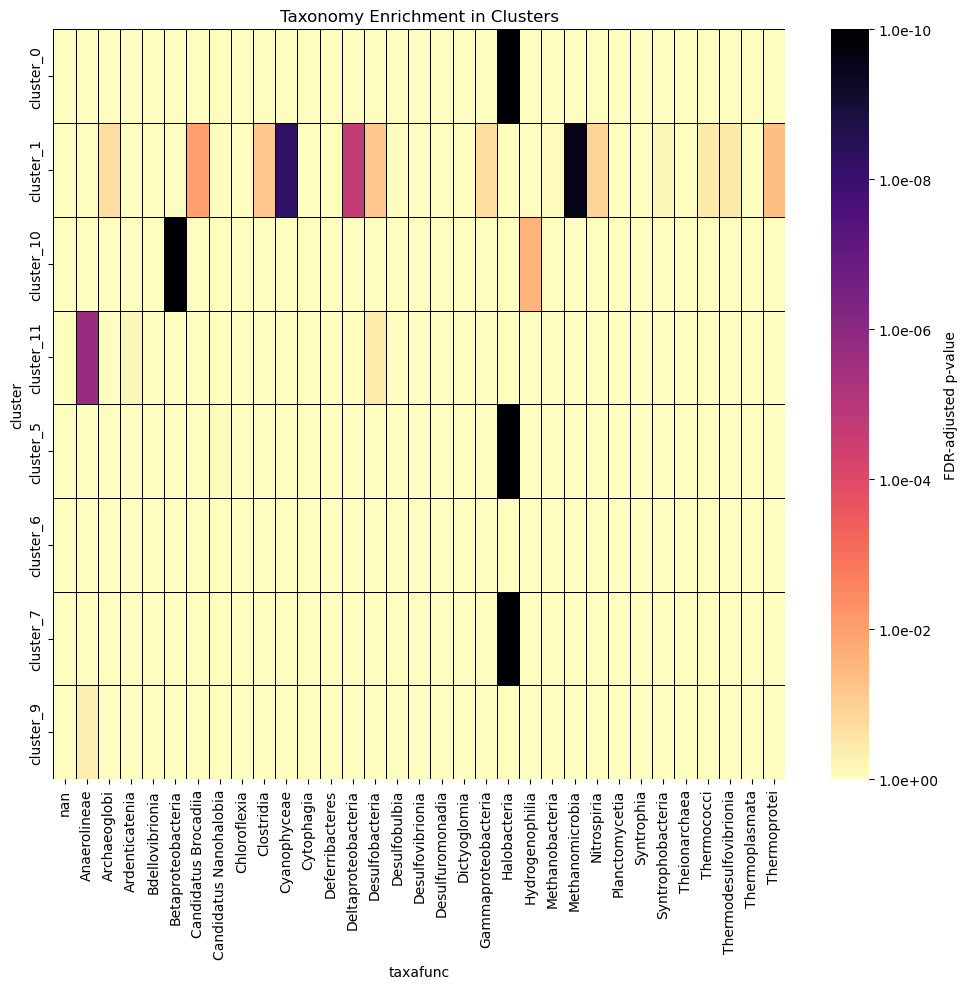

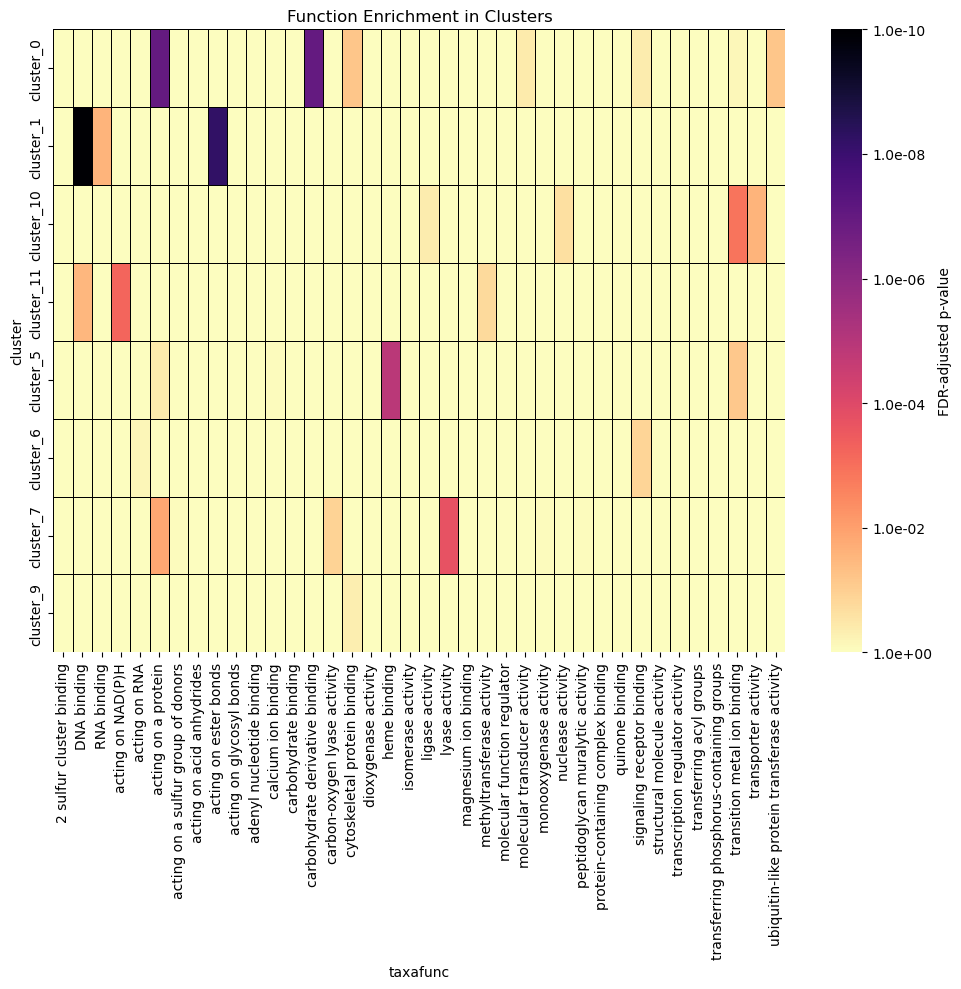

In [49]:
## Taxonomy and Function Enrichment analysis with Fisher's exact test and plotting the heatmap
# Fisher's exact test enrichment analysis
def fisher_enrichment(data, cluster_method, taxafunc_method, min_cluster_size=2):
    results = []

    # Remove the small clusters
    cluster_counts = data[cluster_method].value_counts()
    valid_clusters = cluster_counts[cluster_counts >= min_cluster_size].index
    data_filtered = data[data[cluster_method].isin(valid_clusters)]

    clusters = data_filtered[cluster_method].unique()
    taxafuncs = data_filtered[taxafunc_method].unique()

    # Calculate the p-value from Fisher exact test
    for cluster in clusters:
        for taxafunc in taxafuncs:
            in_cluster = data_filtered[cluster_method] == cluster
            is_taxafunc = data_filtered[taxafunc_method] == taxafunc

            a = ((in_cluster) & (is_taxafunc)).sum()
            b = ((in_cluster) & (~is_taxafunc)).sum()
            c = ((~in_cluster) & (is_taxafunc)).sum()
            d = ((~in_cluster) & (~is_taxafunc)).sum()

            if (a + b > 0) and (c + d > 0):
                odds_ratio, p_value = fisher_exact([[a, b], [c, d]], alternative='greater')
                results.append({
                    'cluster': cluster,
                    'taxafunc': taxafunc,
                    'count_in_cluster': a,
                    'total_in_cluster': a + b,
                    'odds_ratio': odds_ratio,
                    'p_value': p_value
                })
    
    # Use -log10 to see the p values on the heatmap
    df_result = pd.DataFrame(results)
    df_result['adjusted_p'] = multipletests(df_result['p_value'], method='fdr_bh')[1]
    df_result['-log10_p'] = -np.log10(df_result['adjusted_p'] + 1e-10)

    return df_result

# Plot the heatmap of the enrichment analysis
def plot_enrichment_heatmap(df_enrich, title):
    heatmap_data = df_enrich.pivot(index='cluster', columns='taxafunc', values='-log10_p')

    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(
        heatmap_data,
        cmap='magma_r',
        cbar_kws={'label': 'p-value'},
        vmin=0, # corresponds to p = 1
        vmax=10, # corresponds to p = 1e-10
        linewidths=0.5,
        linecolor='black'
    )

    # Customize colorbar ticks to show real p-values
    colorbar = ax.collections[0].colorbar
    log_ticks = colorbar.get_ticks()
    pvalue_ticks = [10**(-tick) for tick in log_ticks]
    tick_labels = [f"{p:.1e}" for p in pvalue_ticks]
    colorbar.set_ticks(log_ticks)
    colorbar.set_ticklabels(tick_labels)
    colorbar.set_label("FDR-adjusted p-value")

    plt.title(title)
    plt.tight_layout()
    plt.show()

# Calculate the taxonomy enrichment and the function enrichment
taxonomy_results = fisher_enrichment(TumE_annotations, cluster_method, taxonomy_level, min_cluster_size)
function_results = fisher_enrichment(TumE_annotations, cluster_method, 'deepfri consensus', min_cluster_size)

plot_enrichment_heatmap(taxonomy_results, "Taxonomy Enrichment in Clusters")
plot_enrichment_heatmap(function_results, "Function Enrichment in Clusters")

##### C) Conclusion


For the **MEME sequence clustering**, all the 9 clusters display a strong enrichment for specific taxonomic groups. 

- It seems that every sequences with **at least one or more of the motifs 1, 3 and 5** seems to be linked with a strong enrichment for `Superkingdom: Archaea`, `Phylum: Euryarchaeaota`, `Class: Halobacteria` etc.
- For sequences with **motif 4**, they seems to be linked with a strong enrichment for `Superkingdom: Bacteria`, `Phylum: (Bacillota, Bacteroidota, etc)`, `Class: (Betaproteobacteria, Anaerolineae, etc.)` etc.
- For sequences with **motif 2**, they seems to be linked with a strong enrichment for `Superkingdom: Bacteria`, `Phylum: (Pseudomonadota, Chloroflexota, etc)`, `Class: (Cyanophyceae, Desulfobacteria, etc.)` etc.

On the function enrichment, only 3 clusters out of 9 display a strong enrichment for specific functional groups.

- Sequences with **motifs 4, 1 and 2 in that order** seems to be linked with `DNA binding` and `acting on ester bonds`
- Sequences with **motifs 3, 1 and 5 in that order** seems to be linked with `acting on protein` and `carbohydrate derivative binding`
- Sequences with **only motif 1** seems to be linked with `heme binding`

For the **Levenshtein ratio sequence clustering**, all the 8 clusters display a strong enrichment for specific taxonomic groups. 

- It seems that sequences in **clusters 0, 5 and 7** seems to be linked with a strong enrichment for `Superkingdom: Archaea`, `Phylum: Euryarchaeaota`, `Class: Halobacteria` etc.
- It seems that sequences in **cluster 6** seems to be linked with a strong enrichment for `Superkingdom: Archaea`, `Phylum: (Candidatus Lokiarchaeota, etc.)` etc.
- For sequences in **cluster 1**, they seems to be linked with a strong enrichment for `Superkingdom: Bacteria`, `Phylum: (Cyanobacteriota, Nitrospirota etc)`, `Class: (Methanomicrobia, Cyanophyceae, etc.)` etc.
- For sequences in **cluster 10**, they seems to be linked with a strong enrichment for `Superkingdom: Bacteria`, `Phylum: Pseudomonadota`, `Class: (Betaproteobacteria, etc.)` etc.
- For sequences in **clusters 9 and 11**, they seems to be linked with a strong enrichment for `Superkingdom: Bacteria`, `Phylum: Chloroflexota`, `Class: Anaerolineae` etc.

On the function enrichment, only 6 clusters out of 8 display a strong enrichment for specific functional groups.

- Sequences in **cluster 0** seems to be linked with `acting on protein` and `carbohydrate derivative binding`
- Sequences in **cluster 1** seems to be linked with `DNA binding`, `RNA binding` and `acting on ester bonds`
- Sequences in **cluster 10** seems to be linked with `transition metal ion binding` and `transporter activity`
- Sequences in **cluster 11** seems to be linked with `DNA binding` and `acting on NAD(P)H`
- Sequences in **cluster 5** seems to be linked with `heme binding`
- Sequences in **cluster 7** seems to be linked with `acting on protein` and `lyase activity`

On the **MMseqs with sequence identity 0.5** we have really low enrichment in functional groups (less than 10) showing the using kmers strategies might not be the best to link functional groups in the TumE Superfamily. 3/4 of the clusters have strong enrichment in taxonomic groups with this method.

With the **amino acid densities method** we have strong enrichment in both functional and taxonomic groups but it seems like a lot of small clusters were lost in the process.

#### **Question 3:** What is the importance of applying computational approches in biomedical research, particularly in the investigation of gut microbiota? Support your argument with a detailed exploration of 1-2 examples from the TumE superfamily dataset. You can use the type II toxin-antitoxin system discovery in Durairaj et al. 2023 for insipration.

##### A) Explaining the importance of applying computational approaches in biomedical research, particularly in the investigation of gut microbiota

- Computational approaches help analyze large-scale, multi-omics gut microbiota datasets. They enable extraction of meaningful biological hypotheses through tools like network analysis and machine learning revealing relationships and interactions at a scale impossible without computational methods.

- These methods reduce experimental burden by uncovering statistically significant associations, guiding experiments toward the most promising hypotheses. This prioritization helps optimize resources by reducing the number of required experiments and accelerating discovery.

- Identifying protein families with both functional and taxonomic associations using computational tools can target specific proteins more effectively. This speeds up the path to therapeutic applications, as shown by examples from the TumE superfamily.

##### B) First example of a protein family investigation

A protein family defined by **MEME motifs** arranged in the order **4 → 1 → 2**, and classified within **Levenshtein cluster 1**, appears to be associated with taxa such as `Methanomicrobia, Cyanophyceae, and other classes`. Functionally, this family is linked to `DNA binding` and `acting on ester bonds`.

- **Motif 4:** IEKLKYSYHWQDABG
- **Motif 1:** IFRYDNAPHHP
- **Motif 2:** ELSTFPHHKHIGDEI

These conserved motif patterns, along with their taxonomic and functional associations, highlight this family as a candidate for further study in `Ester bonds activity` and `DNA binding`.

##### C) Second example of a protein family investigation

A protein family defined by **MEME motifs** arranged in the order **3 → 1 → 5**, and classified within **Levenshtein cluster 0**, appears to be associated with the class `Halobacteria`. Functional signatures suggest roles in `acting on protein` and `carbohydrate derivative binding`.

- **Motif 3:** SARLDIRWYTNGDFSFHYVE
- **Motif 1:** IFRYDNAPHHP
- **Motif 5:** NPRDHFHPPPDASTPGADDS

These conserved motif patterns, along with their taxonomic and functional associations, highlight this family as a candidate for further study in `protein activity` and `carbohydrate derivative binding`.